This is based on a tutorial from Susan Li, [published on Medium](https://towardsdatascience.com/sales-forecasting-with-price-promotion-effects-b5d70207b128). The purpose is to "analyze the historical data using time series analysis techniques, with promotion effect."

My goal is to learn how to apply time series to questions around pricing

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.distributions.empirical_distribution import ECDF

pd.set_option('display.max_columns', 50)

In [46]:
df = pd.read_csv("Sales_Product_Price_by_Store.csv")

Just getting a sense of what is in this dataset

In [33]:
df.head()

,Store,Product,Date,Is_Holiday,Base Price,Price,Weekly_Units_Sold
0,1,1,2/5/2010,False,9.99,7.99,245
1,1,1,2/12/2010,True,9.99,7.99,453
2,1,1,2/19/2010,False,9.99,7.99,409
3,1,1,2/26/2010,False,9.99,7.99,191
4,1,1,3/5/2010,False,9.99,9.99,145


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861 entries, 0 to 3860
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Store              3861 non-null   int64  
 1   Product            3861 non-null   int64  
 2   Date               3861 non-null   object 
 3   Is_Holiday         3861 non-null   bool   
 4   Base Price         3861 non-null   float64
 5   Price              3861 non-null   float64
 6   Weekly_Units_Sold  3861 non-null   int64  
dtypes: bool(1), float64(2), int64(3), object(1)
memory usage: 184.9+ KB


In [35]:
#do all the stores sell for the same price?
df.groupby(['Store']).mean()

,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold
Store,,,,,
1,2.0,0.06993,12.554103,11.766084,202.095571
2,2.0,0.06993,12.554103,11.766084,283.135198
3,2.0,0.06993,12.554103,11.766084,73.867133
4,2.0,0.06993,12.554103,11.766084,369.972028
5,2.0,0.06993,12.554103,11.766084,63.636364
6,2.0,0.06993,12.554103,11.766084,227.734266
7,2.0,0.06993,12.554103,11.766084,102.627040
8,2.0,0.06993,12.554103,11.766084,152.151515
10,2.0,0.06993,12.554103,11.766084,468.354312


In [47]:
#create columns for the day of week, month, year
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.weekday
df['week_of_year'] = df.index.weekofyear
df.head()

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,year,month,day,day_of_week,week_of_year
Date,,,,,,,,,,,
2010-02-05,1,1,False,9.99,7.99,245,2010,2,5,4,5
2010-02-12,1,1,True,9.99,7.99,453,2010,2,12,4,6
2010-02-19,1,1,False,9.99,7.99,409,2010,2,19,4,7
2010-02-26,1,1,False,9.99,7.99,191,2010,2,26,4,8
2010-03-05,1,1,False,9.99,9.99,145,2010,3,5,4,9


In [41]:
df.head(20)

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,year,month,day,day_of_week,week_of_year,weekly_sales
Date,,,,,,,,,,,,
2010-02-05,1,1,False,9.99,7.99,245,2010,2,5,4,5,1957.55
2010-02-12,1,1,True,9.99,7.99,453,2010,2,12,4,6,3619.47
2010-02-19,1,1,False,9.99,7.99,409,2010,2,19,4,7,3267.91
2010-02-26,1,1,False,9.99,7.99,191,2010,2,26,4,8,1526.09
2010-03-05,1,1,False,9.99,9.99,145,2010,3,5,4,9,1448.55
2010-03-12,1,1,False,9.99,9.99,140,2010,3,12,4,10,1398.60
2010-03-19,1,1,False,9.99,9.99,147,2010,3,19,4,11,1468.53
2010-03-26,1,1,False,9.99,9.99,175,2010,3,26,4,12,1748.25
2010-04-02,1,1,False,9.99,9.99,382,2010,4,2,4,13,3816.18


In [48]:
#create a weekly sales values column
df['weekly_sales'] = df['Price'] * df['Weekly_Units_Sold']

In [49]:
#what day of the week has most sales?
df.groupby(['day_of_week']).mean()

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,year,month,day,week_of_year,weekly_sales
day_of_week,,,,,,,,,,,
4,5.111111,2.0,0.06993,12.554103,11.766084,215.952603,2010.965035,6.447552,15.678322,25.818182,1896.054685


In [50]:
#what month has most sales?
df.groupby(['month']).mean()

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,year,day,day_of_week,week_of_year,weekly_sales
month,,,,,,,,,,,
1,5.111111,2.0,0.000000,12.823333,12.823333,156.453704,2011.500000,17.000000,4.0,2.500000,1564.509537
2,5.111111,2.0,0.250000,12.545556,11.834444,218.651235,2011.000000,14.500000,4.0,6.500000,1921.512253
3,5.111111,2.0,0.000000,12.554103,12.554103,167.381766,2011.076923,15.384615,4.0,10.692308,1543.551254
4,5.111111,2.0,0.000000,12.537619,11.846190,271.367725,2010.928571,15.785714,4.0,15.142857,1856.990476
5,5.111111,2.0,0.000000,12.545556,11.834444,169.845679,2011.000000,16.166667,4.0,19.500000,1450.970062
6,5.111111,2.0,0.000000,12.554103,12.554103,155.980057,2011.076923,14.384615,4.0,23.692308,1392.896040
7,5.111111,2.0,0.000000,12.537619,8.397143,392.097884,2010.928571,15.785714,4.0,28.142857,2842.942275
8,5.111111,2.0,0.000000,12.554103,12.554103,225.213675,2011.076923,16.384615,4.0,32.692308,2755.038462
9,5.111111,2.0,0.230769,12.579744,12.579744,167.085470,2011.000000,15.692308,4.0,37.000000,1595.198091


Plotting the ECDF... Remind me again, **what is ECDF?**
Empirical Cumulative Distribution Function [This is helpful.](https://statisticsbyjim.com/graphs/empirical-cumulative-distribution-function-cdf-plots/)
* Empirical because it's about observed data
* Cumulative becuase it's a cumulative probability
* Distribution because it's a probability distribution across our dataset
* Function because it's a calculation

**And what does it represent?**
In our case, we will look at weekly sales. The x axis is weekly sales, and the y axis is a probability function. 

**And how do I use it to understand this dataset?**
There's a sharp increase at about 500 sales. Most of our weeks have sales around this (or below). The most sales was 2500 -- but the long flat line tells us that that was not normal. 



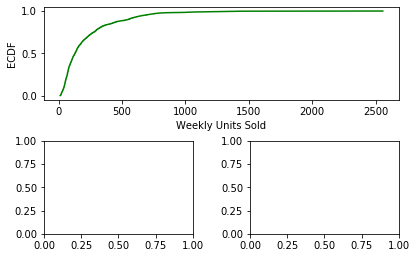

In [58]:
figure, axes = plt.subplots(nrows=2, ncols=2)
figure.tight_layout(pad=2.0)
plt.subplot(211)
cdf = ECDF(df['Weekly_Units_Sold'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = 'green');
plt.xlabel('Weekly Units Sold'); plt.ylabel('ECDF');
plt.show()

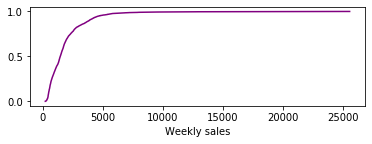

In [60]:
plt.subplot(212)
cdf = ECDF(df['weekly_sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = 'purple');
plt.xlabel('Weekly sales');
plt.show()